### Notebook del modelo de fraude

####  Importando librerias

In [1]:
import os
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import plot_roc_curve

from scipy import stats
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tools import TemporalStability, Plot

#### Lectura de la base de datos

In [2]:
data_ = pd.read_csv('credit_card_transactions-ibm_v2_pipelined.csv.zip',
                    usecols=['Date', 'Card', 'Amount FE', 'MCC FE',
                            'Merchant State FE', 'Use Chip FE', 'target'],
                    compression='zip')

data_['target'] = data_['target'].astype(int)
print(data_.shape)
data_.head(1)

(7313559, 7)


,Card,Amount FE,MCC FE,Merchant State FE,Use Chip FE,Date,target
0,0,5.0,4.0,1.0,1.0,2015-01-01,0


#### Balanceamiento de la base de datos

In [3]:
balancing_factor = 1000

data_target_1 = data_.query("target == 1")
print('Casos con Fraude = 1: ', data_target_1.shape[0])

data_target_0 = data_.query("target == 0").sample(balancing_factor * data_target_1.shape[0])
print('Casos con Fraude = 0: ',data_target_0.shape[0])

data = pd.concat([data_target_1, data_target_0])
print('Tamaño base final: ',data.shape[0])
print('Porcentual (final) de casos de fraude: ', (100.*data['target'].mean()))

Casos con Fraude = 1:  1031
Casos con Fraude = 0:  1031000
Tamaño base final:  1032031
Porcentual (final) de casos de fraude:  0.0999000999000999


#### Definición de las variables que entrarán en el modelo.

In [4]:
model_features = ['Card','Amount FE','MCC FE','Merchant State FE','Use Chip FE']

#### Cuantificando el número de casos por trimestre.

In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data['periodo'] = data['Date'].dt.strftime('%Y%m')
data['trimestre'] = data['Date'].dt.to_period("Q")

In [6]:
counts = data.groupby('trimestre')['target'].count()
means  = data.groupby('trimestre')['target'].mean()*100
df_nQ = pd.DataFrame(data={'counts':counts, 'means':means})
df_nQ.head(100)

,counts,means
trimestre,,
2015Q1,48351,0.006205
2015Q2,49252,0.290344
2015Q3,50039,0.303763
2015Q4,49491,0.414217
2016Q1,48623,0.294100
2016Q2,49387,0.303724
2016Q3,49815,0.236876
2016Q4,49980,0.188075
2017Q1,49094,0.000000


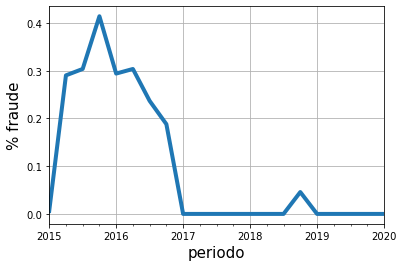

In [7]:
df_nQ.means.plot(lw=4)
plt.xlabel('periodo', size=15)
plt.ylabel('% fraude', size=15)
plt.grid()

**Nota**: se ha detectado que la proporción de casos de fraude es despreciable a partir de 2017. Se entiende que se puede tratar de un efecto normal dado que los datos son fictícios. Para simular lo que sería el entrenamiento de un modelo real de fraude, **se ha decidido seleccionar únicamente los datos entre las fechas 2015 y 2017**. Meses que sí muestran pequeñas tasas de fraude. 

#### Selección de fechas mínimas y máximas para el modelo.

In [8]:
min_date = '2015-01-01' 
max_date = '2017-01-01'

In [9]:
print(data.shape[0])
data = data.query("(periodo >= '%s') & (periodo <= '%s')"%(min_date, max_date))
print(data.shape[0])

1032031
394938


####  Selección de muestras para el entrenamiento y validación del modelo

* **Train**: muestra usada para entrenar modelo.
* **OOS (Out of Sample)**: muestra de validación en el mismo periodo de entrenamiento.
* **OOT (Out of Time)**: muestra de validación en periodo distinto al de entrenamiento.

Vamos a visualizar la cantidad de registros para definir las diversas muestras

#### Cantidad de registros por trimestre

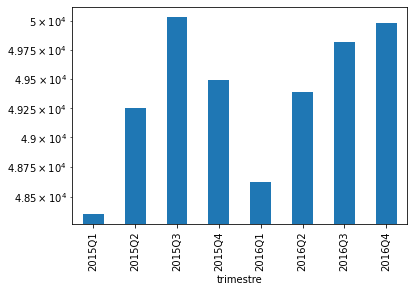

In [10]:
data.groupby('trimestre')['target'].count().plot.bar()
plt.yscale('log')

#### Train, OOS & OOT splitting

In [11]:
min_date_oot   = '2016-09-01'
max_date_oot   = '2017-01-01'

In [12]:
# train & oos
df_trainval = data.query("(periodo <= '%s')"%(min_date_oot)).copy()
df_trainval['type'] = 'train'

# oot
df_test = data.query("(periodo >= '%s')"%(min_date_oot)).copy()
df_test = df_test.query("(periodo <= '%s')"%(max_date_oot))
df_test['type'] = 'oot'

#### Separación de muestra "Training" en train & oos

In [13]:
frac_test = 0.15
random_number = np.random.randint(1,100)
print('random number for this trial: ', random_number)

x_train_, x_oos_, y_train_, y_oos_ = train_test_split(df_trainval, 
                                                      df_trainval, 
                                                      test_size=frac_test,
                                                      random_state=random_number)

random number for this trial:  44


In [14]:
x_train = x_train_[model_features]
x_oos   = x_oos_[model_features]
y_train = y_train_['target']
y_oos   = y_oos_['target']
x_oos['type'] = 'oos' # since this is a new element
X_oot_ = df_test.copy() 
X_oot = df_test[model_features]
Y_oot = df_test['target'] 

### Entrenamiento del modelo:

* Se usará un **Random Forest Classifier** porque permite definir **pesos estadísticos** para entrenar mejor **muestras desbalanceadas**. 
* Se definirá un pequeño espacio de **hyper-parameters** para simular un proceso de optimización de modelos. La función **_RandomizedSearchCV_** realiza una rápida exploración de dicho espacio de parámetros.

In [15]:
rf = RandomForestClassifier()

# hyper-parameter space for RF
rf_param_grid = {'n_estimators': [5, 10, 50],
                 'max_depth': [None, 2, 5, 10],
                 'class_weight': [{0:1, 1:10}, {0:1, 1:50}, 
                                  {0:1, 1:500}, {0:1, 1:1000}],
                }


random_search = RandomizedSearchCV(rf, 
                                   param_distributions = rf_param_grid, 
                                   n_iter = 10,
                                   cv = 3,
                                   scoring = 'roc_auc', 
                                   n_jobs = -1, 
                                   random_state = 10, #rng = np.random.RandomState(0)
                                   refit = False,
                                   verbose = False
                                  ).fit(x_train, y_train)

#### Identificación de los mejores hyper-parameters para entrenar el modelo final.

In [16]:
print(random_search.best_params_)

{'n_estimators': 50, 'max_depth': 5, 'class_weight': {0: 1, 1: 50}}


In [17]:
rf_model = RandomForestClassifier(n_estimators = 50, 
                                  max_depth = 2, 
                                  class_weight = {0: 1, 1: 10}
                                 ).fit(x_train, y_train)

#### Observación de la importancia de las variables

In [18]:
importances = rf_model.feature_importances_
feature_names = [f'feature {i}' for i in range(x_train.shape[1])]
feature_names = [f'{i}' for i in model_features]
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

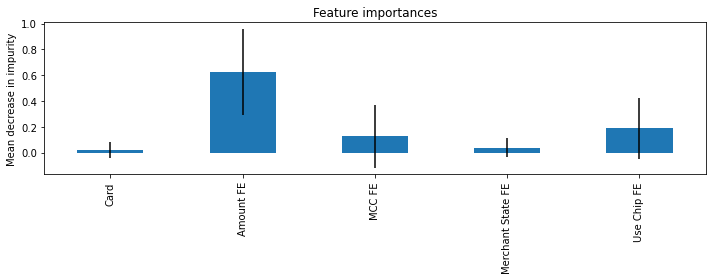

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#####  Resultado: 
+ Se observa que las variables más importantes en la estimación de fraude serían "Amount FE" y "Use Chip FE", siendo la menos importante la variable "Card".

#### En caso de querer salvar  (__serialize__) nuestro modelo para su uso posterior.

In [20]:
save_model = 1
if save_model:
    with open("fraud_model.pkl", "wb") as f:
         pickle.dump(rf_model, f, -1)
    
    if os.path.exists("fraud_model.pkl"):
        print(" Model saved successfully! ")

#### Cálculo de las probabilidades del modelo para cada muestra.

In [21]:
train_predproba = rf_model.predict_proba(x_train) 
oos_predproba   = rf_model.predict_proba(x_oos.iloc[:,:-1])
oot_predproba   = rf_model.predict_proba(X_oot)

### Validación del modelo.

In [22]:
cv_n = 2

Train_CV_acc = np.round(cross_val_score(rf_model, x_train, y_train, cv=cv_n, verbose=0).mean(),3)
OOS_CV_acc   = np.round(cross_val_score(rf_model, x_oos.iloc[:,:-1], y_oos, cv=cv_n).mean(),3)
OOT_CV_acc   = np.round(cross_val_score(rf_model, X_oot, Y_oot, cv=cv_n).mean(),3)

CV_acc_df    = pd.DataFrame()
CV_acc_df['acc'] = np.asarray([Train_CV_acc, OOS_CV_acc, OOT_CV_acc])
CV_acc_df.index = ['Train', 'OOS', 'OOT']
CV_acc_df.head(3)

,acc
Train,0.997
OOS,0.998
OOT,0.997


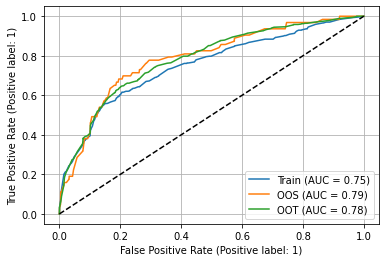

In [23]:
fig, ax = plt.subplots()

plot_roc_curve(rf_model, x_train, y_train, ax=ax, name='Train')
plot_roc_curve(rf_model, x_oos.iloc[:,:-1], y_oos, ax=ax, name='OOS')
plot_roc_curve(rf_model, X_oot, Y_oot, ax=ax, name='OOT')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), 'k--')
plt.legend(facecolor='white')
plt.grid()

#####  Resultado: 
+ Los valores de la métrica accuracy (acc) son muy elevados para las tres muestras. Es un resultado esperado dado que el grado de desbalanceamiento de los datos es muy elevado, y esta métrica es más sensible hacia la clase dominante en los datos. 
+ La figura muestra los valores obtenidos para la métricas roc-auc que es más sensible a ambas clases. Se observa tanto un valor elevado (lo que indica una buena clasificación) como unas distribuciones similares para las 3 muestras (Train, OOS, OOT). 
+ Estos resultados demuestran una alta capacidad de clasificación y de estabilidad del modelo. 

#### Visualización de las distribuciones de probabilidad (de fraude) para las 3 muestras previamente definidas.

In [24]:
new_df_train = pd.DataFrame(train_predproba, columns=['P0', 'P1'])
new_df_train['target'] = y_train.values

new_df_oos = pd.DataFrame(oos_predproba, columns=['P0', 'P1'])
new_df_oos['target'] = y_oos.values

new_df_oot = pd.DataFrame(oot_predproba, columns=['P0', 'P1'])
new_df_oot['target'] = Y_oot.values

Text(0.5, 1.0, 'oot')

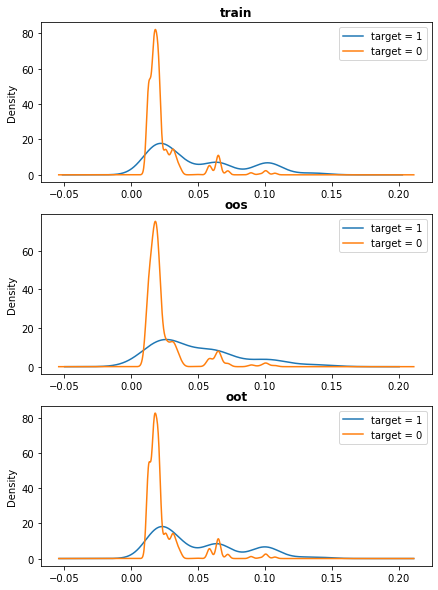

In [25]:
plt.figure(1, figsize=(7,10))
label_a = 'target = 1'
label_b = 'target = 0'
plt.subplot(3,1,1)
new_df_train.query("target == 1")['P1'].plot.kde(label=label_a)
new_df_train.query("target == 0")['P1'].plot.kde(label=label_b)
plt.legend(loc='best')
plt.title('train', weight='bold')

plt.subplot(3,1,2)
new_df_oos.query("target == 1")['P1'].plot.kde(label=label_a)
new_df_oos.query("target == 0")['P1'].plot.kde(label=label_b)
plt.legend(loc='best')
plt.title('oos', weight='bold')

plt.subplot(3,1,3)
new_df_oot.query("target == 1")['P1'].plot.kde(label=label_a)
new_df_oot.query("target == 0")['P1'].plot.kde(label=label_b)
plt.legend(loc='best')
plt.title('oot', weight='bold')

#####  Resultado: 
+ Como se verá más adelante, el modelo, aunque básico, ya muestra dos elementos importantes:
    1. **Se observa una estabilidad en las distribuciones de probabilidad a lo largo de los 3 periodos**. Este hecho le confiere al modelo una "estabilidad temporal", que permite asegurar que, cuando entre en funcionamiento, continuará funcionando con la misma calidad que observamos en los periodos de entrenamiento.

    2. **Se observa una clara discriminación de fraude**. Donde hay una concentración de "buenos" clientes del lado izquierdo (valores pequeños de probabilidad de ser "fraude") y una cola larga de "malos" clientes del lado derecho. Esto va a permitir identificar grupos con alta concentración de fraude y eliminarlos de nuestra actividad comercial. 

#### Modelo KS: Kolmogorov-Smirnov test

In [26]:
ks_train = stats.ks_2samp(new_df_train.query("target==0")['P1'].values, new_df_train.query("target==1")['P1'].values)[0]
ks_oos   = stats.ks_2samp(new_df_oos.query("target==0")['P1'].values, new_df_oos.query("target==1")['P1'].values)[0]
ks_oot   = stats.ks_2samp(new_df_oot.query("target==0")['P1'].values, new_df_oot.query("target==1")['P1'].values)[0]

KS_df = pd.DataFrame()
KS_df['KS'] = np.asarray([ks_train, ks_oos, ks_oot])
KS_df.index = ['Train', 'OOS', 'OOT']
KS_df.round(3).head(3)

,KS
Train,0.411
OOS,0.489
OOT,0.443


#####  Resultado: 
Los valores observados de KS, para las tres muestras, muestran el siguiente resultado:
+ Alta **capacidad discriminante** entre públicos (Fraude y No Fraude).
+ Muestran valores similares, indicando una **alta estabilidad** del modelo.
    

#### Estabilidad temporal del modelo: por meses

In [27]:
# definición de parámetros para el estudio temporal.
resampling_timescale_ = '1 M'
temporal_variable_ = 'Date'
target_variable_ = 'target'

In [28]:
df_results_train = new_df_train.copy()
df_results_train['Date'] = x_train_['Date'].values
df_results_train['type'] = 'train' 

df_results_oos = new_df_oos.copy()
df_results_oos['Date'] = x_oos_['Date'].values
df_results_oos['type'] = 'oos'

df_results_oot = new_df_oot.copy()
df_results_oot['Date'] = X_oot_['Date'].values
df_results_oot['type'] = 'oot' 

df_results_ = pd.concat([df_results_train, df_results_oos, df_results_oot], axis=0)

df_results_ = df_results_.sort_values(by='Date')
df_results_ = df_results_.reset_index(drop=True)
df_results_['Date'] = pd.to_datetime(df_results_['Date'])

Uso de una función externa ("TemporalStability") para dicho análisis

In [29]:
df_metrics = TemporalStability(df = df_results_.query("type in ['oos','oot']"),
                               score_variable = 'P1', 
                               target_variable = target_variable_, 
                               temporal_variable = temporal_variable_, 
                               resampling_timescale = resampling_timescale_, 
                               metric = 'all')

In [30]:
df_metrics.MetricValues().head(5)
periods_ = df_metrics.periods() 
dts_ = df_metrics.dts() 
df_results_.type.value_counts()

oot      197805
train    167563
oos       29570
Name: type, dtype: int64

In [31]:
# Reemplazando datos faltantes por valores médios en caso de necesidad
df_metrics_MetricValues = df_metrics.MetricValues().fillna(value=np.mean(df_metrics.MetricValues()))

#### Visualización de las diferentes métricas: [ Verde = OOS, Rojo = OOT ]

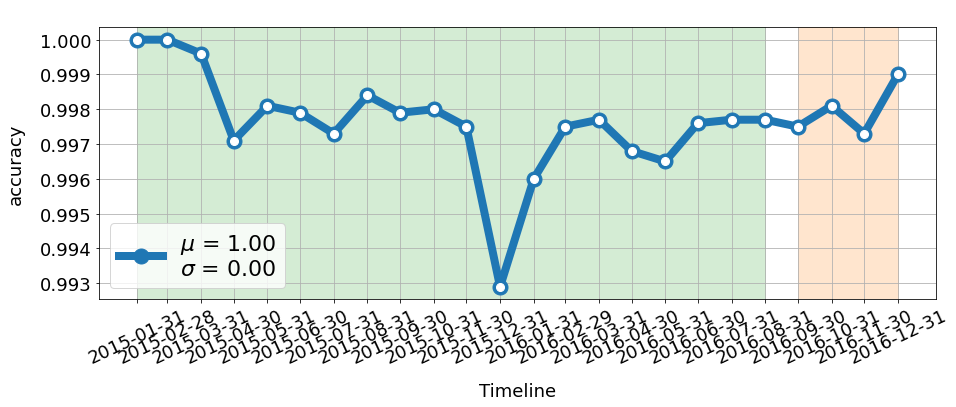

In [32]:
metric = 'accuracy'
Plot(dts_, df_metrics_MetricValues[metric].values, ' ', metric, True, '1', min_date_oot)

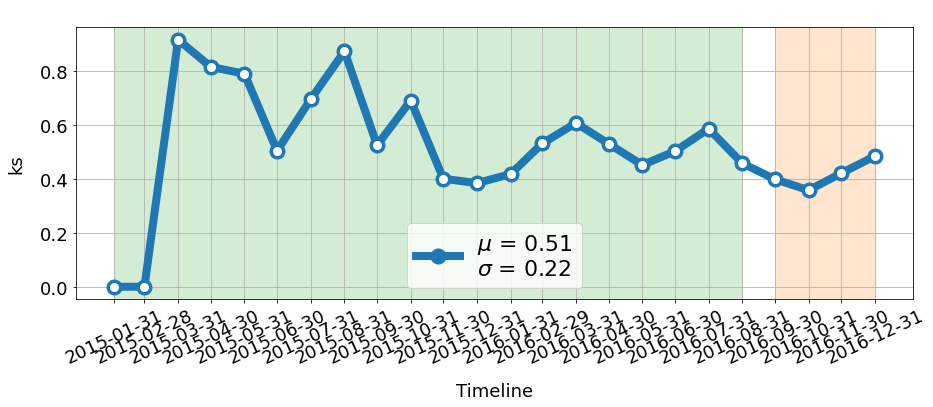

In [33]:
metric = 'ks'
Plot(dts_, df_metrics_MetricValues[metric].values, ' ', metric, True, '1', min_date_oot)

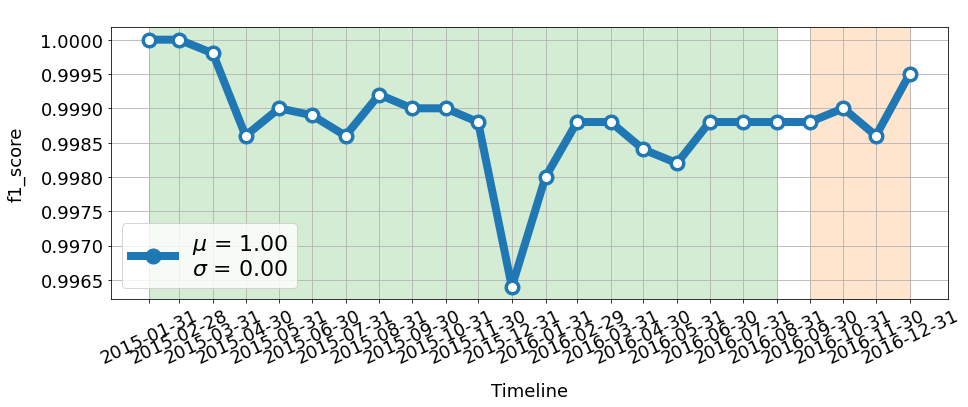

In [34]:
metric = 'f1_score'
Plot(dts_, df_metrics_MetricValues[metric].values, ' ', metric, True, '1', min_date_oot)

#####  Resultado: 
+ Las métricas utilizadas indican que el modelo presenta un clara **estabilidad a lo largo de los meses**. 

#### Calculo de las probabilidades de Fraude para toda la base

In [35]:
score_name = 'score'
data[score_name] = rf_model.predict_proba(data[model_features])[:,1]

#### Estudio de la estabilidad de la distribución de probabilidad por mes (toda la muestra)

In [36]:
df_ts = data[['Date', 'score', 'target']].copy()
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts['period'] = pd.to_datetime(df_ts['Date'].dt.to_period('M').astype(str))
df_ts = df_ts.sort_values(by='period')
df_ts['period'] = df_ts['period'].astype(str)

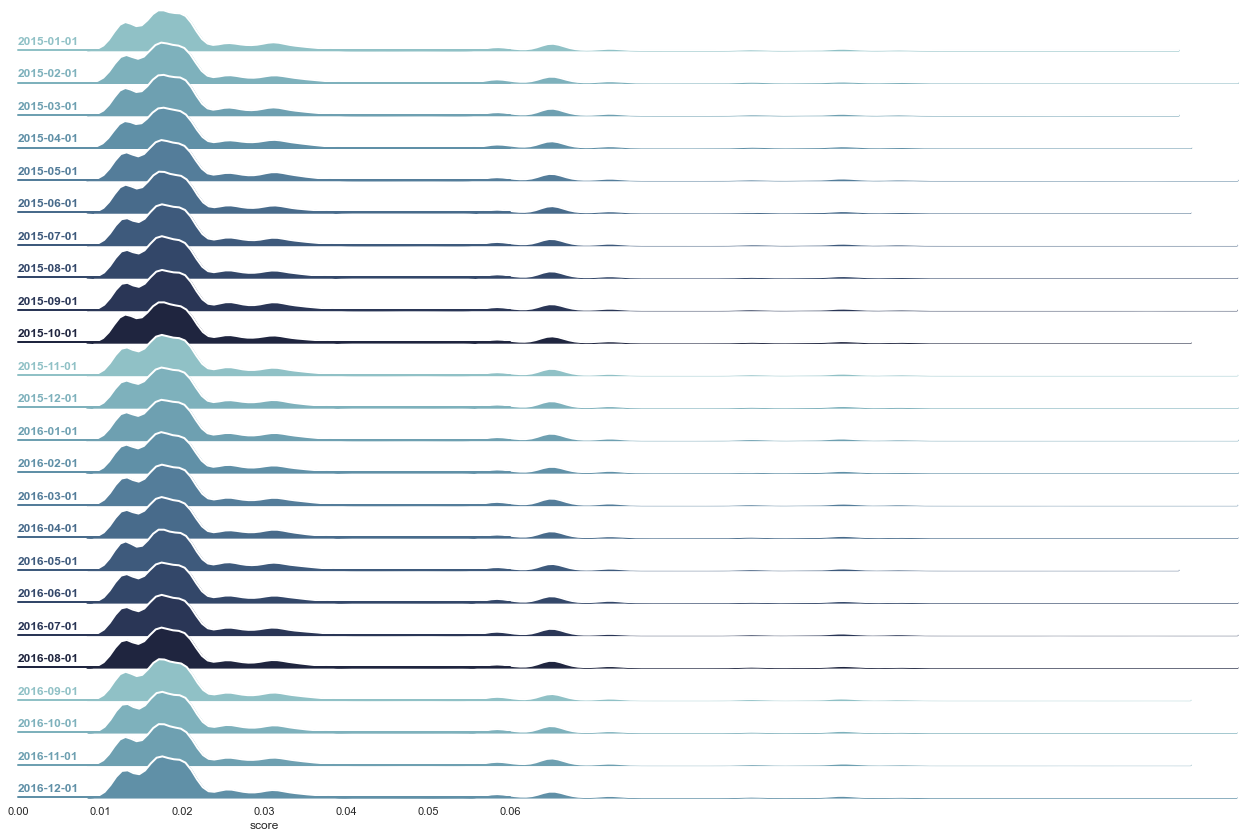

In [37]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)


g = sns.FacetGrid(df_ts, 
                  row="period", 
                  hue="period", 
                  aspect=15, 
                  height=.5, 
                  palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, score_name,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, score_name, clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, score_name)
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)
# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.set(xlim=[0.,0.06])
g.despine(bottom=True, left=True)

#####  Resultado: 
+ La figura superior muestra una buena estabilidad del modelo mes a mes. Este resultado es importante para garantizar que el modelo se comportará de forma esperada en los próximos meses. 

Text(0, 0.5, 'Probability')

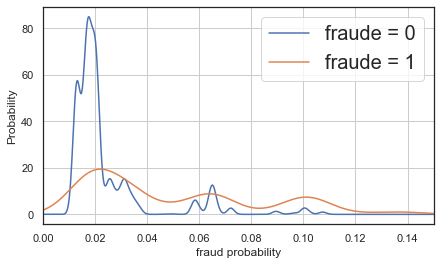

In [39]:
plt.figure(1, figsize=(7,4))
data.query("(target==0)")[score_name].plot.kde(label='fraude = 0')
data.query("(target==1)")[score_name].plot.kde(label='fraude = 1')

plt.legend(facecolor='white', fontsize=20)
plt.title('')
plt.xlim(0.,0.15)
plt.grid()
plt.xlabel('fraud probability')
plt.ylabel('Probability')

#### Cuantificación de la tasa de fraude esperada por grupo de clientes

In [40]:
n_bins = 5

In [41]:
data['bin_model'], bins_ = pd.qcut(data[score_name], q=n_bins, labels=False, retbins=True, duplicates='drop')
data['bin_model'] = data['bin_model']+1
data.head(1)

,Card,Amount FE,MCC FE,Merchant State FE,Use Chip FE,Date,target,periodo,trimestre,score,bin_model
2079,2,8.0,1.0,1.0,1.0,2016-03-01,1,201603,2016Q1,0.020924,4


#### Distribución de casos por grupo (bin)

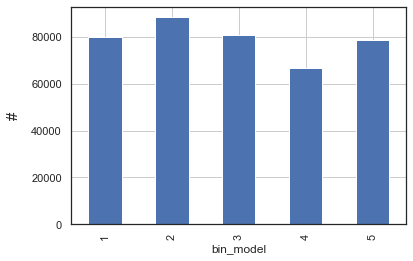

In [42]:
data.groupby('bin_model')['target'].count().plot.bar()
plt.ylabel('#', fontsize=15, labelpad=10)
#plt.legend()
plt.grid()

#### Proporción de casos de fraude por grupo (bin)

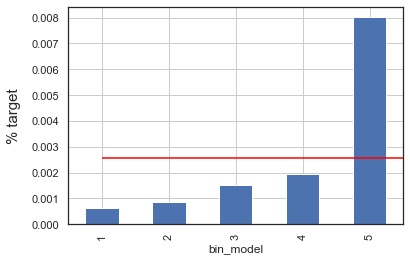

In [43]:
data.groupby('bin_model')['target'].mean().plot.bar(label='target_oc')
plt.hlines(data['target'].mean(), 0, n_bins, colors='red')
plt.ylabel('% target', fontsize=15, labelpad=10)
plt.grid()

#####  Resultado:
+ Se observa que el modelo tiene una alta capacidad de segmentar clientes con altas tasas de fraude (bin = 5). De la misma forma, identifica grupos de clientes con tasas de fraude menores a la tasa promedio (bin = 1, 2, 3, 4). 
+ Este resultado es importante puesto que permitirá identificar (y eliminar) grupos de alto riesgo. 

#### Ejemplo de segmentación de clientes por bin de probabilidad de fraude

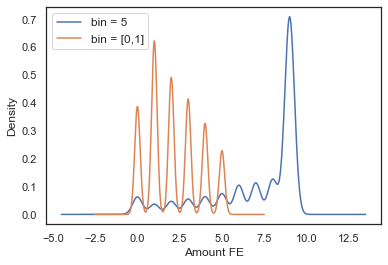

In [56]:
data.query("bin_model == 5")['Amount FE'].plot.kde(label='bin = 5')
data.query("bin_model in [0,1]")['Amount FE'].plot.kde(label='bin = [0,1]')
plt.legend(facecolor='white', ncol=1, fontsize=12)
plt.xlabel('Amount FE');

#####  Resultado:
+ En este ejemplo se muestra la capacidad de segmentación del modelo para dos grupos distintos de clientes. Dicha segmentación es más asertiva que la utilización de una variable individual para separar buenos de malos clientes. 